# Set up EDB for Power Distribution Network Analysis
This example shows how to set up the electronics database (EDB) for power integrity analysis from a single
configuration file.

## Perform imports and define constants

Perform required imports.

In [1]:
import json
import os
import tempfile

import matplotlib.pyplot as plt

from ansys.aedt.core import Hfss3dLayout
from ansys.aedt.core.examples.downloads import download_file
from pyedb import Edb

Define constants.

In [2]:
AEDT_VERSION = "2025.2"
NG_MODE = False

Download the example PCB data.

In [3]:
temp_folder = tempfile.TemporaryDirectory(suffix=".ansys")
download_file(source="touchstone", name="GRM32_DC0V_25degC_series.s2p", local_path=temp_folder.name)
file_edb = download_file(source="edb/ANSYS-HSD_V1.aedb", local_path=temp_folder.name)

## Load example layout

In [4]:
edbapp = Edb(file_edb, edbversion=AEDT_VERSION)

C:\actions-runner\_work\pyaedt-examples\pyaedt-examples\.venv\lib\site-packages\pyedb\misc\decorators.py:55: UserWarning: Argument `edbversion` is deprecated for method `Edb`; use `version` instead.
  warnings.warn(
C:\actions-runner\_work\pyaedt-examples\pyaedt-examples\.venv\lib\site-packages\pyedb\generic\design_types.py:301: UserWarning: Your ANSYS AEDT version is eligible to gRPC version.You might consider switching to that version for better user experience.For more information please check this link: https://edb.docs.pyansys.com/version/dev/grpc_api/index.html
  warnings.warn(GRPC_GENERAL_WARNING, UserWarning)


PyEDB INFO: Star initializing Edb 10:33:48.115137


PyEDB INFO: Edb version 2025.2


PyEDB INFO: Logger is initialized. Log file is saved to C:\Users\ansys\AppData\Local\Temp\pyedb_ansys.log.


PyEDB INFO: legacy v0.67.1


PyEDB INFO: Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]


PyEDB INFO: Database ANSYS-HSD_V1.aedb Opened in 2025.2


PyEDB INFO: Cell main Opened


PyEDB INFO: Builder was initialized.


PyEDB INFO: open_edb completed in 9.0672 seconds.


PyEDB INFO: EDB initialization completed in 9.1367 seconds.


## Create an empty dictionary to host all configurations

In [5]:
cfg = dict()

## Assign S-parameter model to capactitors.

Set S-parameter library path.

In [6]:
cfg["general"] = {"s_parameter_library": os.path.join(temp_folder.name, "touchstone")}

Assign the S-parameter model.

Keywords

- **name**. Name of the S-parameter model in AEDT.
- **component**_definition. Known as component part number of part name.
- **file_path**. Touchstone file or full path to the touchstone file.
- **apply_to_all**. When set to True, assign the S-parameter model to all components share the same
component_definition. When set to False, Only components in "components" are assigned.
- **components**. when apply_to_all=False, components in the list are assigned an S-parameter model.
When apply_to_all=False, components in the list are NOT assigned.
- **reference_net**. Reference net of the S-parameter model.

In [7]:
cfg["s_parameters"] = [
    {
        "name": "GRM32_DC0V_25degC_series",
        "component_definition": "CAPC0603X33X15LL03T05",
        "file_path": "GRM32_DC0V_25degC_series.s2p",
        "apply_to_all": False,
        "components": ["C110", "C206"],
        "reference_net": "GND",
    }
]

## Define ports
Create a circuit port between power and ground nets.

Keywords

- **name**. Name of the port.
- **reference_desinator**.
- **type**. Type of the port. Supported types are 'ciruict', 'coax'.
- **positive_terminal**. Positive terminal of the port. Supported types are 'net', 'pin', 'pin_group', 'coordinates'.
- **negative_terminal**. Positive terminal of the port. Supported types are 'net', 'pin', 'pin_group', 'coordinates'.

In [8]:
cfg["ports"] = [
    {
        "name": "port1",
        "reference_designator": "U1",
        "type": "circuit",
        "positive_terminal": {"net": "1V0"},
        "negative_terminal": {"net": "GND"},
    }
]

## Define SIwave SYZ analysis setup

Keywords

- **name**. Name of the setup.
- **type**. Type of the analysis setup. Supported types are 'siwave_ac', 'siwave_dc', 'hfss'.
- **pi_slider_position**. PI slider position. Supported values are from '0', '1', '2'. 0:speed, 1:balanced,
2:accuracy.
- **freq_sweep**. List of frequency sweeps.
  - **name**. Name of the sweep.
  - **type**. Type of the sweep. Supported types are 'interpolation', 'discrete', 'broadband'.
  - **frequencies**. Frequency distribution.
    - **distribution**. Supported distributions are 'linear_count', 'linear_scale', 'log_scale'.
    - **start**. Start frequency. Example, 1e6, "1MHz".
    - **stop**. Stop frequency. Example, 1e9, "1GHz".
    - **increment**.

In [9]:
cfg["setups"] = [
    {
        "name": "siwave_syz",
        "type": "siwave_ac",
        "pi_slider_position": 1,
        "freq_sweep": [
            {
                "name": "Sweep1",
                "type": "interpolation",
                "frequencies": [{"distribution": "log_scale", "start": 1e6, "stop": 1e9, "increment": 20}],
            }
        ],
    }
]

## Define Cutout

Keywords

- **signal_list**. List of nets to be kept after cutout.
- **reference_list**. List of nets as reference planes.
- **extent_type**. Supported extend types are 'Conforming', 'ConvexHull', 'Bounding'.
For optional input arguments, refer to method pyedb.Edb.cutout()

In [10]:
cfg["operations"] = {
    "cutout": {
        "signal_list": ["1V0"],
        "reference_list": ["GND"],
        "extent_type": "ConvexHull",
    }
}

## Write configuration into as json file

In [11]:
file_json = os.path.join(temp_folder.name, "edb_configuration.json")
with open(file_json, "w") as f:
    json.dump(cfg, f, indent=4, ensure_ascii=False)

## Import configuration into example layout

In [12]:
edbapp.configuration.load(config_file=file_json)

Apply configuration to EDB.

In [13]:
edbapp.configuration.run()

PyEDB INFO: Updating nets finished. Time lapse 0:00:00


PyEDB INFO: Updating components finished. Time lapse 0:00:00


PyEDB INFO: Creating pin groups finished. Time lapse 0:00:00


PyEDB INFO: Placing sources finished. Time lapse 0:00:00


PyEDB INFO: Applying materials finished. Time lapse 0:00:00


PyEDB INFO: Updating stackup finished. Time lapse 0:00:00


PyEDB INFO: Applying padstack definitions and instances completed in 0.0000 seconds.


PyEDB INFO: Applying S-parameters finished. Time lapse 0:00:00.015697


PyEDB INFO: Applying package definitions finished. Time lapse 0:00:00


PyEDB INFO: Applying modeler finished. Time lapse 0:00:00


PyEDB INFO: Placing ports finished. Time lapse 0:00:00.726592


PyEDB INFO: Placing terminals completed in 0.0000 seconds.


PyEDB INFO: Placing probes finished. Time lapse 0:00:00


PyEDB INFO: -----------------------------------------


PyEDB INFO: Trying cutout with (0.002)*(1000.0)mm expansion size


PyEDB INFO: -----------------------------------------


PyEDB INFO: Cutout Multithread started.


C:\actions-runner\_work\pyaedt-examples\pyaedt-examples\.venv\lib\site-packages\pydantic\main.py:464: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Unexpected Value)
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [field_name='resistor_below', input_value=100, input_type=int])
  PydanticSerializationUnexpectedValue(Unexpected Value)
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [field_name='inductor_below', input_value=1, input_type=int])
  return self.__pydantic_serializer__.to_python(


PyEDB INFO: Net clean up Elapsed time: 0m 1sec


PyEDB INFO: Extent Creation Elapsed time: 0m 0sec


PyEDB INFO: 1310 Padstack Instances deleted. Elapsed time: 0m 1sec


PyEDB INFO: 265 Primitives deleted. Elapsed time: 0m 3sec


PyEDB INFO: 702 components deleted


PyEDB INFO: Cutout completed. Elapsed time: 0m 5sec


PyEDB INFO: EDB file save completed in 0.0793 seconds.


PyEDB INFO: Cutout completed in 1 iterations with expansion size of (0.002)*(1000.0)mm Elapsed time: 0m 5sec


PyEDB INFO: Applying operations completed in 5.2145 seconds.


True

Save and close EDB.

In [14]:
edbapp.save()
edbapp.close()

PyEDB INFO: Save Edb file completed in 0.0635 seconds.


PyEDB INFO: Close Edb file completed in 0.0810 seconds.


True

The configured EDB file is saved in a temp folder.

In [15]:
print(temp_folder.name)

C:\Users\ansys\AppData\Local\Temp\tmpt0yqxki0.ansys


## Load edb into HFSS 3D Layout.

In [16]:
h3d = Hfss3dLayout(edbapp.edbpath, version=AEDT_VERSION, non_graphical=NG_MODE, new_desktop=True)

PyAEDT INFO: Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)].


PyAEDT INFO: PyAEDT version 0.25.dev0.


PyAEDT INFO: Initializing new Desktop session.


PyAEDT INFO: Log on console is enabled.


PyAEDT INFO: Log on file C:\Users\ansys\AppData\Local\Temp\pyaedt_ansys_6df52e52-5124-479c-9c7f-f8b9787e614d.log is enabled.


PyAEDT INFO: Log on AEDT is disabled.


PyAEDT INFO: Starting new AEDT gRPC session.


PyAEDT INFO: AEDT installation Path C:\Program Files\ANSYS Inc\v252\AnsysEM


PyAEDT INFO: Client application successfully started.


PyAEDT INFO: New AEDT gRPC session session started on port 50051.


PyAEDT INFO: 2025.2 version started with process ID 1332.


PyAEDT WARNING: Service Pack is not detected. PyAEDT is currently connecting in Insecure Mode.


PyAEDT WARNING: Please download and install latest Service Pack to use connect to AEDT in Secure Mode.


PyAEDT INFO: Debug logger is disabled. PyAEDT methods will not be logged.


PyAEDT INFO: EDB folder C:\Users\ansys\AppData\Local\Temp\tmpt0yqxki0.ansys\edb\ANSYS-HSD_V1.aedb has been imported to project ANSYS-HSD_V1


PyAEDT INFO: Active Design set to 0;main


PyAEDT INFO: Active Design set to 0;main


PyAEDT INFO: Aedt Objects correctly read


## Analyze

In [17]:
h3d.analyze()

PyAEDT INFO: Project ANSYS-HSD_V1 Saved correctly


PyAEDT INFO: Solving all design setups. Analysis started...


PyAEDT INFO: Design setup None solved correctly in 0.0h 0.0m 40.0s


True

## Plot impedance

PyAEDT INFO: Parsing C:\Users\ansys\AppData\Local\Temp\tmpt0yqxki0.ansys\edb\ANSYS-HSD_V1.aedt.


PyAEDT INFO: File C:\Users\ansys\AppData\Local\Temp\tmpt0yqxki0.ansys\edb\ANSYS-HSD_V1.aedt correctly loaded. Elapsed time: 0m 0sec


PyAEDT INFO: aedt file load time 0.30022120475769043


PyAEDT INFO: PostProcessor class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: Post class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: Loading Modeler.


PyAEDT INFO: Modeler loaded.


PyAEDT INFO: Modeler class has been initialized! Elapsed time: 0m 0sec


PyEDB INFO: Star initializing Edb 10:35:08.327141


PyEDB INFO: Edb version 2025.2


PyEDB INFO: Logger is initialized. Log file is saved to C:\Users\ansys\AppData\Local\Temp\pyedb_ansys.log.


PyEDB INFO: legacy v0.67.1


PyEDB INFO: Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]


PyEDB INFO: Database ANSYS-HSD_V1.aedb Opened in 2025.2


PyEDB INFO: Cell main Opened


PyEDB INFO: Builder was initialized.


PyEDB INFO: open_edb completed in 0.1352 seconds.


PyEDB INFO: EDB initialization completed in 0.1511 seconds.


PyAEDT INFO: EDB loaded.


C:\actions-runner\_work\pyaedt-examples\pyaedt-examples\.venv\lib\site-packages\pyedb\generic\design_types.py:301: UserWarning: Your ANSYS AEDT version is eligible to gRPC version.You might consider switching to that version for better user experience.For more information please check this link: https://edb.docs.pyansys.com/version/dev/grpc_api/index.html
  warnings.warn(GRPC_GENERAL_WARNING, UserWarning)


PyAEDT WARNING: No report category provided. Automatically identified Standard


PyAEDT INFO: Solution Data Correctly Loaded.


Time to initialize solution data:0.0
Time to initialize solution data:0.01566934585571289


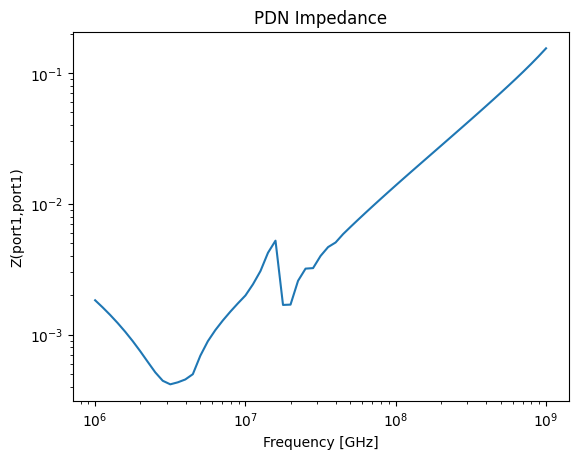

In [18]:
solutions = h3d.post.get_solution_data(expressions="Z(port1,port1)")
plot_data = solutions.get_expression_data(convert_to_SI=True, formula="mag")
x, y = plot_data
plt.plot(x, y)
plt.title("PDN Impedance")
plt.xlabel("Frequency [GHz]")
plt.ylabel("Z(port1,port1)")
plt.xscale("log")
plt.yscale("log")
plt.show()

## Shut Down Electronics Desktop

In [19]:
h3d.close_desktop()

PyAEDT INFO: Desktop has been released and closed.


True

All project files are saved in the folder ``temp_file.dir``. If you've run this example as a Jupyter notebook you
can retrieve those project files.